In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')
df.shape

(20560, 7)

In [3]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date'] 
df['Day']=df['Data'].dt.dayofweek
del df['Data']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Day,Hour,Month,Year
0,23.18,27.2720,426.0,721.25,0.004793,1,2,17,2,2015
1,23.15,27.2675,429.5,714.00,0.004783,1,2,17,2,2015
2,23.15,27.2450,426.0,713.50,0.004779,1,2,17,2,2015
3,23.15,27.2000,426.0,708.25,0.004772,1,2,17,2,2015
4,23.10,27.2000,426.0,704.50,0.004757,1,2,17,2,2015


In [4]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [5]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Day,Hour,Month,Year,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,2,17,2,2015,1
1,23.15,27.2675,429.5,714.00,0.004783,2,17,2,2015,1
2,23.15,27.2450,426.0,713.50,0.004779,2,17,2,2015,1
3,23.15,27.2000,426.0,708.25,0.004772,2,17,2,2015,1
4,23.10,27.2000,426.0,704.50,0.004757,2,17,2,2015,1


## Partitioning

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score ,cross_val_predict

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [7]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

## Classificatori

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [12]:
from sklearn.naive_bayes import GaussianNB

In [13]:
naive = GaussianNB()
naive.fit(X_train, y_train)
y_pred_naive = naive.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred_naive))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4743
           1       0.88      1.00      0.93      1425

    accuracy                           0.97      6168
   macro avg       0.94      0.98      0.96      6168
weighted avg       0.97      0.97      0.97      6168



In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
logis = LogisticRegression(random_state=0)
logis.fit(X_train, y_train)
y_pred_logis = logis.predict(X_test)

C:\Users\monia\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [17]:
print(classification_report(y_test, y_pred_logis))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_train,y_train)
y_pred_tree = tree.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.98      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



## Variance threshold

In [21]:
from sklearn.feature_selection import VarianceThreshold

In [22]:
sel = VarianceThreshold(threshold=(1.2))
X_train_sel = sel.fit_transform(X_train)
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(14392, 5)

In [23]:
knn_new=KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_new.fit(X_train_sel, y_train)
y_pred_knn_new = knn_new.predict(X_test_sel)

In [24]:
print(classification_report(y_test, y_pred_knn_new))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [25]:
naive_new=GaussianNB()
naive_new.fit(X_train_sel, y_train)
y_pred_naive_new = naive_new.predict(X_test_sel)

In [26]:
print(classification_report(y_test, y_pred_naive_new))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      4743
           1       0.91      1.00      0.95      1425

    accuracy                           0.98      6168
   macro avg       0.96      0.98      0.97      6168
weighted avg       0.98      0.98      0.98      6168



In [27]:
logis_new = LogisticRegression(random_state=0)
logis_new.fit(X_train_sel, y_train)
y_pred_logis_new = logis_new.predict(X_test_sel)

In [28]:
print(classification_report(y_test, y_pred_logis_new))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [29]:
tree_new=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree_new.fit(X_train_sel,y_train)
y_pred_tree_new = tree_new.predict(X_test_sel)

In [30]:
print(classification_report(y_test, y_pred_tree_new))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.98      0.98      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.98      0.98      6168
weighted avg       0.99      0.99      0.99      6168



# Univariate Feature Selection

In [31]:
from sklearn.feature_selection import SelectKBest

In [32]:
sel = SelectKBest(k=9)
X_train_sel = sel.fit_transform(X_train, y_train)

X_train_sel.shape

C:\Users\monia\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [7 8] are constant.
  UserWarning)
C:\Users\monia\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(14392, 9)

non toglie nessuna features

# Recursive Feature Elimination


In [33]:
from sklearn.feature_selection import SelectFromModel

In [34]:
sel = SelectFromModel(DecisionTreeClassifier())
X_train_sel = sel.fit_transform(X_train, y_train)
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(14392, 1)

In [35]:
knn_neww=KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_neww.fit(X_train_sel, y_train)
y_pred_knn_neww = knn_neww.predict(X_test_sel)

In [36]:
print(classification_report(y_test, y_pred_knn_neww))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.96      0.99      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168



In [37]:
naive_new=GaussianNB()
naive_new.fit(X_train_sel, y_train)
y_pred_naive_new = naive_new.predict(X_test_sel)

In [38]:
print(classification_report(y_test, y_pred_naive_new))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4743
           1       0.89      1.00      0.94      1425

    accuracy                           0.97      6168
   macro avg       0.94      0.98      0.96      6168
weighted avg       0.97      0.97      0.97      6168



In [39]:
logis_new = LogisticRegression(random_state=0)
logis_new.fit(X_train_sel, y_train)
y_pred_logis_new = logis_new.predict(X_test_sel)

In [40]:
print(classification_report(y_test, y_pred_logis_new))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4743
           1       0.95      1.00      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.97      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168



In [41]:
tree_new=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree_new.fit(X_train_sel,y_train)
y_pred_tree_new = tree_new.predict(X_test_sel)

In [42]:
print(classification_report(y_test, y_pred_tree_new))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.96      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.98      6168
weighted avg       0.99      0.99      0.99      6168



## PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)

In [10]:
X_train_pca.shape

(14392, 8)

In [11]:
explained_variance = pca.explained_variance_ratio_
explained_variance #il 90% della varianza è spiegata dal primo e secondo principal component

array([7.76179191e-01, 2.23291081e-01, 3.50991915e-04, 1.52499399e-04,
       2.29074871e-05, 3.32930446e-06, 1.06443907e-14, 0.00000000e+00])

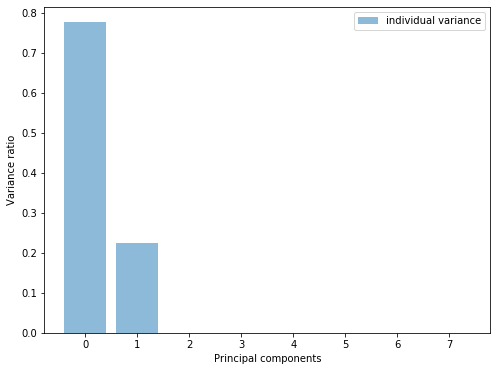

In [12]:
plt.figure(figsize=(8, 6))
plt.bar(range(8), explained_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [13]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [14]:
X_train_pca.shape

(14392, 2)

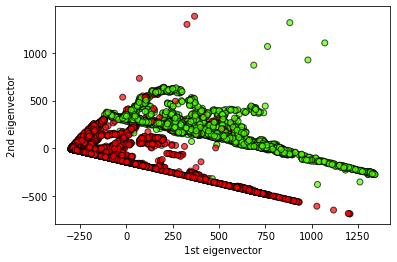

In [15]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

In [47]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9863813229571985
F1-score [0.99115417 0.97042254]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.97      0.97      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.98      0.98      6168
weighted avg       0.99      0.99      0.99      6168



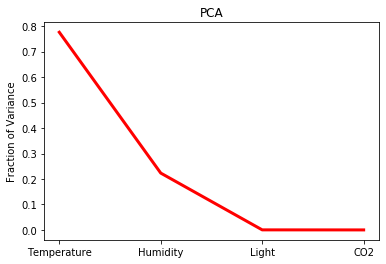

In [48]:
plt.plot(PCA(n_components=4).fit(X_train).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(4),feature_names)
plt.show()

In [53]:
logis_new = LogisticRegression(random_state=0)
logis_new.fit(X_train_pca, y_train)
y_pred_logis_new = logis_new.predict(X_test_pca)
print(classification_report(y_test, y_pred_logis_new))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.96      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



In [54]:
naive_new=GaussianNB()
naive_new.fit(X_train_pca, y_train)
y_pred_naive_new = naive_new.predict(X_test_sel)

In [55]:
print(classification_report(y_test, y_pred_naive_new))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4743
           1       0.83      1.00      0.90      1425

    accuracy                           0.95      6168
   macro avg       0.91      0.97      0.94      6168
weighted avg       0.96      0.95      0.95      6168



In [56]:
knn_neww=KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_neww.fit(X_train_pca, y_train)
y_pred_knn_neww = knn_neww.predict(X_test_pca)

In [57]:
print(classification_report(y_test, y_pred_knn_neww))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      0.99      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168

